# Preprocess
Preparing proper and ready-to-use train-validate-test datasets for modelling.
<br>You can see summary of the process in the cell output along with time taken.

In [1]:
import time
preprocess_start_time = time.time()
import os
import pandas as pd
INPUT_DIR = os.path.join(os.path.dirname(os.getcwd()), 'input', 'celeba-subset')
TXT = 'list_attribute.txt'
INPUT_IMAGES_DIR = os.path.join(INPUT_DIR, 'Images')
INPUT_IMAGES_LIST = os.listdir(INPUT_IMAGES_DIR)


print("\nCopying image files to ./images, please wait...")
start_time = time.time()
import shutil
IMAGES_DIR = os.path.join(os.getcwd(), 'images')
try:
    shutil.rmtree(IMAGES_DIR)
    os.rmdir(IMAGES_DIR)
    print(f"'{IMAGES_DIR}' is found. Deleted successfully.")
    os.makedirs(IMAGES_DIR, exist_ok=True)
    print(f"'{IMAGES_DIR}' is created")
except FileNotFoundError:
    pass
shutil.copytree(INPUT_IMAGES_DIR, IMAGES_DIR, dirs_exist_ok=True)
inference_time = time.time() - start_time
print("Finished in {:.6f} seconds".format(inference_time))


print("\nFinding and removing duplicates, please wait...")
start_time = time.time()
from PIL import Image
import imagehash
def remove_duplicate_images(directory):
    image_hash_map = {}
    removed_files = [] 
    for filename in os.listdir(directory):
        if not filename.endswith(('.png', '.jpg', '.jpeg')):
            continue
        if "(1)" in filename:
            os.remove(os.path.join(directory, filename))
            removed_files.append(filename)  
            continue
        with open(os.path.join(directory, filename), 'rb') as f:
            img = Image.open(f)
            img_hash = imagehash.average_hash(img)
        if img_hash in image_hash_map:
            os.remove(os.path.join(directory, filename))
            removed_files.append(filename) 
        else:
            image_hash_map[img_hash] = filename          
    return removed_files 

removed_files = remove_duplicate_images(IMAGES_DIR)
for filename in removed_files:
    print("Removed:", filename)
print(f"Number of files in {IMAGES_DIR}: {len(os.listdir(IMAGES_DIR))}")
inference_time = time.time() - start_time
print("Finished in {:.6f} seconds".format(inference_time))


print(f"\nConverting {TXT} to a dataframe then filter it down to the filename and male feature.")
start_time = time.time()
df_preprocess = pd.read_csv(os.path.join(INPUT_DIR, TXT), sep="\s+", index_col=0, skiprows=1)
df_preprocess = df_preprocess[['Male']]
inference_time = time.time() - start_time
print("Finished in {:.6f} seconds".format(inference_time))

print("\nReordering dataframe columns..")
start_time = time.time()
df_preprocess.reset_index(inplace=True)          # Reset index to make it a leftmost column
df_preprocess = df_preprocess[['index', 'Male']] # Reorder columns
df_preprocess.columns = ['Filename', 'Male']     # Rename the columns if needed
inference_time = time.time() - start_time
print("Finished in {:.6f} seconds".format(inference_time))


print("\nSyncing dataframe with files in .input/celeba-subset/Images")
start_time = time.time()
df_preprocess = df_preprocess[df_preprocess['Filename'].isin(os.listdir(IMAGES_DIR))] 
if len(df_preprocess) == len(os.listdir(IMAGES_DIR)):
    match_str = " (MATCH)"
else:
    match_str = ""
print(f"Number of rows in dataframe: {len(df_preprocess)}{match_str}")
inference_time = time.time() - start_time
print("Finished in {:.6f} seconds".format(inference_time))


print("\nEncoding the -1 in Male to 0 to facilitate the use of Binary Crossentropy Loss later.")
start_time = time.time()
df_preprocess.loc[ df_preprocess['Male'] == -1, ['Male'] ] = 0
inference_time = time.time() - start_time
print("Finished in {:.6f} seconds".format(inference_time))


print("\nReset dataframe index & reorder columns")
start_time = time.time()
df_preprocess.reset_index(inplace=True)
# df_preprocess = df_preprocess[['index', 'Male']]
df_preprocess = df_preprocess[['Filename', 'Male']]
# df_preprocess.columns = ['Filename', 'Male']
inference_time = time.time() - start_time
print("Finished in {:.6f} seconds".format(inference_time))


print("\nTrain : Validate : Test = 70 : 20 : 10")
print("Moving files from ./images to ./train/male ./train/female ./val/male ./val/female ./test/male ./test/female")
print("Please wait..")
from functools import partial
from typing import Tuple
from sklearn.model_selection import train_test_split 

def create_directory(directory: str) -> None:
    os.makedirs(directory, exist_ok=True)

def create_train_test_val_dirs() -> Tuple[str, str, str, str, str, str]:
    train_dir_female = os.path.join(os.getcwd(), 'train', 'female')
    train_dir_male = os.path.join(os.getcwd(), 'train', 'male')
    test_dir_female = os.path.join(os.getcwd(), 'test', 'female')
    test_dir_male = os.path.join(os.getcwd(), 'test', 'male')
    val_dir_female = os.path.join(os.getcwd(), 'val', 'female')
    val_dir_male = os.path.join(os.getcwd(), 'val', 'male')
    # Create directories if they don't exist
    for directory in [train_dir_female, train_dir_male, test_dir_female, test_dir_male, val_dir_female, val_dir_male]:
        create_directory(directory)
    return train_dir_female, train_dir_male, test_dir_female, test_dir_male, val_dir_female, val_dir_male

df_train, df_validate_test = train_test_split(df_preprocess, test_size=0.3, random_state=42, stratify=df_preprocess['Male'])
df_val, df_test = train_test_split(df_validate_test, test_size=1/3, random_state=42, stratify=df_validate_test['Male'])
train_dir_female, train_dir_male, test_dir_female, test_dir_male, val_dir_female, val_dir_male = create_train_test_val_dirs()
combined_df = pd.concat([df_train, df_val, df_test])

for index, row in combined_df.iterrows():
    filename, male_value = row[['Filename', 'Male']]
    source_file = os.path.join(IMAGES_DIR, filename)
    if male_value == 1:
        dest_dir = train_dir_male if index in df_train.index else (val_dir_male if index in df_val.index else test_dir_male)
    else:
        dest_dir = train_dir_female if index in df_train.index else (val_dir_female if index in df_val.index else test_dir_female)
    shutil.move(source_file, os.path.join(dest_dir, filename))

inference_time = time.time() - start_time
print("Finished in {:.6f} seconds".format(inference_time))

print("\nRemoving images directory after processing, please wait...")
shutil.rmtree(IMAGES_DIR)
# os.rmdir(IMAGES_DIR)
inference_time = time.time() - start_time
print("Finished in {:.6f} seconds".format(inference_time))


print("\nYour dataset is ready, here\'s the breakdown:")
train_male_count = len(os.listdir(train_dir_male))
train_female_count = len(os.listdir(train_dir_female))
val_male_count = len(os.listdir(val_dir_male))
val_female_count = len(os.listdir(val_dir_female))
test_male_count = len(os.listdir(test_dir_male))
test_female_count = len(os.listdir(test_dir_female))
train_val_test_count = train_male_count+train_female_count+val_male_count+val_female_count+test_male_count+test_female_count

print(f"{train_dir_male}   : {train_male_count} images ({round(train_male_count/train_val_test_count*100)}%)")
print(f"{train_dir_female} : {train_female_count} images ({round(train_female_count/train_val_test_count*100)}%)")
print(f"{val_dir_male}     : {val_male_count}  images ({round(val_male_count/train_val_test_count*100)}%)")
print(f"{val_dir_female}   : {val_female_count}  images ({round(val_female_count/train_val_test_count*100)}%)")
print(f"{test_dir_male}    : {test_male_count}  images ({round(test_male_count/train_val_test_count*100)}%)")
print(f"{test_dir_female}  : {test_female_count}  images ({round(test_female_count/train_val_test_count*100)}%)")


preprocess_inference_time = time.time() - preprocess_start_time
print("\nPreprocess finished in total of {:.6f} seconds".format(preprocess_inference_time))


Copying image files to ./images, please wait...
Finished in 18.004815 seconds

Finding and removing duplicates, please wait...
Removed: 189513(1).jpg
Removed: 189512(1).jpg
Removed: 189132(1).jpg
Removed: 042861.jpg
Removed: 183005(1).jpg
Removed: 183145(1).jpg
Removed: 183121(1).jpg
Removed: 071482.jpg
Removed: 183050(1).jpg
Removed: 182809(1).jpg
Removed: 182793(1).jpg
Removed: 096459.jpg
Removed: 119135.jpg
Removed: 189581(1).jpg
Removed: 183018(1).jpg
Removed: 163425.jpg
Removed: 089257.jpg
Removed: 189651(1).jpg
Removed: 198095.jpg
Removed: 042877.jpg
Removed: 189297(1).jpg
Removed: 120642.jpg
Removed: 109263.jpg
Removed: 098097.jpg
Removed: 163164.jpg
Removed: 182943(1).jpg
Removed: 033412.jpg
Removed: 024441.jpg
Removed: 182912(1).jpg
Removed: 007566.jpg
Removed: 150707.jpg
Removed: 114141.jpg
Removed: 183111(1).jpg
Removed: 128266.jpg
Removed: 189324(1).jpg
Removed: 029967.jpg
Number of files in /kaggle/working/images: 4981
Finished in 5.025186 seconds

Converting list_attribu

In [3]:
# import os
# import re
# import cv2
# import time
# import difflib
# import requests
# import itertools
# import numpy as np
# import pandas as pd
# import seaborn as sns

# import tensorflow as tf
# import tensorflow.keras.backend as K
# from tensorflow.keras.models import load_model
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras import optimizers, regularizers
# from tensorflow.keras.optimizers import SGD

# from PIL import Image
# from tqdm import tqdm
# from typing import Tuple

# import shutil
# from shutil import rmtree, copytree, copy

# from sklearn import svm
# from sklearn.model_selection import train_test_split#, confusion_matrix
# from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score

# import matplotlib.pyplot as plt, matplotlib.image as mpimg
# from matplotlib import cm
# %matplotlib inline

# import keras
# from keras import layers
# from keras import backend as K
# from keras.models import Sequential
# from keras.optimizers import RMSprop
# from keras.preprocessing.image import load_img
# from keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Activation, GlobalMaxPooling2D
# from keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, Callback

In [4]:
# import os
# import cv2
# import time
# import difflib
# import itertools
# import numpy as np
# import pandas as pd

# import tensorflow as tf
# import tensorflow.keras.backend as K
# from tensorflow import keras#,layers
# from tensorflow.keras import regularizers, optimizers
# from tensorflow.keras.models import load_model
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.optimizers import Adam, Adamax, SGD
# from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, ModelCheckpoint

# import shutil
# from shutil import rmtree, copytree, copy
# from tqdm import tqdm
# from typing import Tuple

# from sklearn import svm
# from sklearn.model_selection import train_test_split#, confusion_matrix
# from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score

# import matplotlib.pyplot as plt, matplotlib.image as mpimg
# from matplotlib import cm
# %matplotlib inline

# import seaborn as sns

# import keras
# from keras import layers
# from keras import backend as K
# from keras.models import Sequential
# from keras.optimizers import RMSprop
# from keras.applications import InceptionV3   
# from keras.preprocessing.image import load_img
# from keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization
# from keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, Callback

In [5]:
# PARENT_DIR = os.path.dirname(os.path.dirname(os.getcwd()))                                  # /
# INPUT_DIR = os.path.join(PARENT_DIR, 'kaggle', 'input', 'input-files2')                      # /kaggle/input/input-files
# ORIG_TXT = os.path.join(INPUT_DIR, 'list_attribute.txt')                                    # /kaggle/input/input-files/list_attribute.txt
# COPY_OF_ORIG_TXT = os.path.join(PARENT_DIR, 'kaggle', 'working', 'list_attribute_copy.txt') # /kaggle/working/list_attribute_copy.txt

In [6]:
# with open(ORIG_TXT, "r") as file:
#   for line in itertools.islice(file, 5):
#     print(line.strip())

In [7]:
# with open(ORIG_TXT) as src, open(COPY_OF_ORIG_TXT, 'w') as dst:
#     lines = src.readlines()
#     header = lines[1].split()
#     male_column_index = header.index("Male")
#     dst.write("Filename " + header[male_column_index] + "\n")
#     for line in lines[2:]:
#         columns = line.split()
#         male_value = columns[male_column_index]
#         if male_value == '-1':
#             male_value = '0'  # Change the value to 0 if it equals -1
#         dst.write(columns[0] + " " + male_value + "\n")

In [8]:
# # Get all filenames within a directory and its subdirectories
# get_filenames = lambda directory: [file for root, _, files in os.walk(directory) for file in files]

# # Get all filenames within INPUT_DIR and its subdirectories
# all_image_filenames = get_filenames(INPUT_DIR)
# all_image_filenames = [os.path.basename(filename) for filename in all_image_filenames]  # Extracting filenames only

# with open(COPY_OF_ORIG_TXT, 'r') as copy_file:
#     copy_filenames = [line.strip().split()[0] for line in copy_file.readlines()[1:]]  # Exclude header

# # Get unmatching filenames from COPY_OF_ORIG_TXT
# matching_filenames = set(all_image_filenames) & set(copy_filenames)
# unmatching_filenames = set(copy_filenames) - matching_filenames

# # Remove unmatching filenames from COPY_OF_ORIG_TXT
# with open(COPY_OF_ORIG_TXT, 'r+') as copy_file:
#     lines = copy_file.readlines()
#     copy_file.seek(0)
#     copy_file.write(lines[0])  # Write the header
#     copy_file.writelines(line for line in lines[1:] if line.split()[0] in matching_filenames)

In [9]:
# # Retrieves filenames within the specified folder, excluding directories.
# def get_filenames(folder):
#     return [file for file in os.listdir(folder) if os.path.isfile(os.path.join(folder, file))]

# # Get filenames from female & male directory
# female_filenames = get_filenames(os.path.join(INPUT_DIR, 'female'))
# male_filenames = get_filenames(os.path.join(INPUT_DIR, 'male'))

# # Create DataFrames for both
# df_female = pd.DataFrame({'Filename': female_filenames, 'Male': 0})
# df_male = pd.DataFrame({'Filename': male_filenames, 'Male': 1})

# # Concatenate both dataframes into df_images
# df_images = pd.concat([df_female, df_male], ignore_index=True)

In [10]:
# # Splitting into train and (validate + test)
# df_train, df_validate_test = train_test_split(df_images, test_size=0.3, random_state=42, stratify=df_images['Male'])

# # Splitting (validate + test) into validate and test
# df_val, df_test = train_test_split(df_validate_test, test_size=1/3, random_state=42, stratify=df_validate_test['Male'])

# print(f"df_train shape: {df_train.shape}")
# print(f"df_val shape: {df_val.shape}")
# print(f"df_test shape: {df_test.shape}")

In [11]:
# def create_directory(directory: str) -> None:
#     shutil.rmtree(directory, ignore_errors=True)
#     os.makedirs(directory)

# def create_train_test_val_dirs() -> Tuple[str, str, str, str, str, str]:
#     create_directory(train_dir_female)
#     create_directory(train_dir_male)
#     create_directory(test_dir_female)
#     create_directory(test_dir_male)
#     create_directory(val_dir_female)
#     create_directory(val_dir_male)

#     return (train_dir_female, train_dir_male, test_dir_female, test_dir_male,
#             val_dir_female, val_dir_male)

# def copy_files(df, target_dirs: Tuple[str, str]) -> None:
#     for index, row in df.iterrows():
#         filename, male_value = row[['Filename', 'Male']]
#         source_file = os.path.join(INPUT_DIR, 'male' if male_value == 1 else 'female', filename)

#         if os.path.exists(source_file):
#             dest_dir = target_dirs[male_value]
#             shutil.copytree(source_file, os.path.join(dest_dir, filename)) if os.path.isdir(source_file) else shutil.copy(source_file, dest_dir)
#         else:
#             print(f"File '{filename}' not found in {INPUT_DIR}/{'male' if male_value == 1 else 'female'}")

# train_dir_female = os.path.join(os.getcwd(), 'train', 'female')
# train_dir_male = os.path.join(os.getcwd(), 'train', 'male')
# test_dir_female = os.path.join(os.getcwd(), 'test', 'female')
# test_dir_male = os.path.join(os.getcwd(), 'test', 'male')
# val_dir_female = os.path.join(os.getcwd(), 'val', 'female')
# val_dir_male = os.path.join(os.getcwd(), 'val', 'male')
    
# train_dir_female, train_dir_male, test_dir_female, test_dir_male, val_dir_female, vale_dir_male = create_train_test_val_dirs()

# copy_files(df_train, (train_dir_male, train_dir_female))
# copy_files(df_test, (test_dir_male, test_dir_female))
# copy_files(df_val, (val_dir_male, val_dir_female))

# Modelling from a predefined popular architecture: Google Research's InceptionV3

## Define the train, validate and test dataframes
These dataframes will be used by the ``ImageDataGenerator``


In [2]:
def create_DF(path):
    label = []
    data = []
    for fold in os.listdir(path):
        fold_path = os.path.join(path, fold)
        for file in os.listdir(fold_path):
            file_path = os.path.join(fold_path, file)
            label.append(fold)
            data.append(file_path)
    LS = pd.Series(label, name='label')
    DS = pd.Series(data, name='filepath')
    DF = pd.concat([DS, LS], axis=1)
    return DF

train_path=os.path.join(os.getcwd(), 'train')
test_path=os.path.join(os.getcwd(), 'test')
val_path=os.path.join(os.getcwd(), 'val')

train_df=create_DF(train_path)
test_df=create_DF(test_path)
val_df=create_DF(val_path)

print(f"train_df shape: {train_df.shape}")
print(f"test_df shape: {test_df.shape}")
print(f"val_df shape: {val_df.shape}")

train_df shape: (3486, 2)
test_df shape: (499, 2)
val_df shape: (996, 2)


## Define generators for training, validating and testing
Image transformation happen here, along with training and testing batch sizes

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32
img_size = (178, 178)
channels = 3 
color = 'rgb'
img_shape = (img_size[0], img_size[1], channels)

ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

def scalar(img):
    return img

tr_gen = ImageDataGenerator(
    #preprocessing_function= scalar, 
    horizontal_flip= True, 
    rescale=1./255,  # Normalize pixel values to [0,1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
)
ts_gen = ImageDataGenerator(
    preprocessing_function= scalar, 
    rescale=1./255
)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepath', y_col= 'label', target_size= img_size, class_mode= 'binary',
                                    color_mode= color, shuffle= True, batch_size= batch_size, seed=42)

val_gen = ts_gen.flow_from_dataframe( val_df, x_col= 'filepath', y_col= 'label', target_size= img_size, class_mode= 'binary',
                                    color_mode= color, shuffle= True, batch_size= batch_size, seed=42)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepath', y_col= 'label', target_size= img_size, class_mode= 'binary',
                                    color_mode= color, shuffle= False, batch_size= test_batch_size, seed=42)

2024-03-17 11:36:02.620302: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-17 11:36:02.620690: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-17 11:36:02.809832: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 3486 validated image filenames belonging to 2 classes.
Found 996 validated image filenames belonging to 2 classes.
Found 499 validated image filenames belonging to 2 classes.


In [ ]:
train_dir = 'Dataset/Train'

train_datagen = preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=32,
    subset="training"
)

valid_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=32,
    subset="validation"
)

## Visualize training dataset

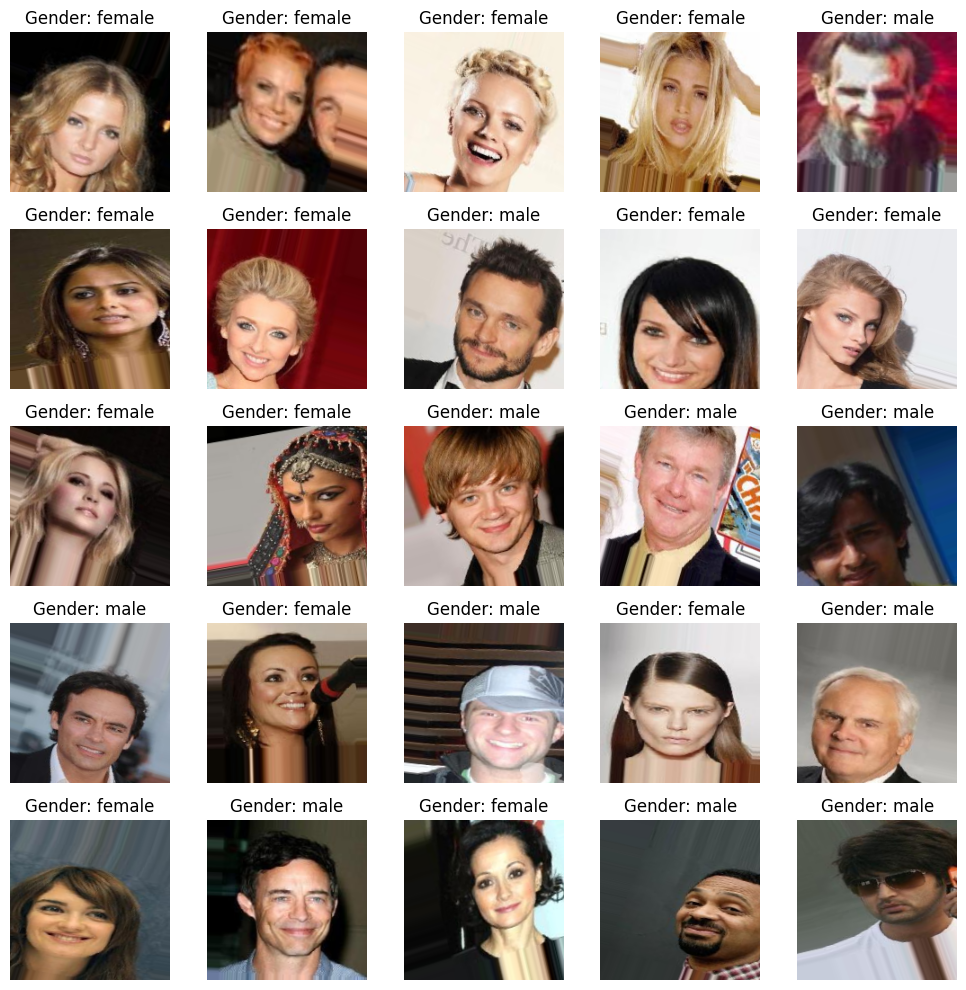

In [8]:
import matplotlib.pyplot as plt

batch = next(train_gen)
fig, axs = plt.subplots(5, 5, figsize=(10, 10))
for i in range(5):
    for j in range(5):
        index = i * 5 + j
        axs[i, j].imshow(batch[0][index])
        axs[i, j].axis('off')
        # Convert numerical label to string representation
        gender_label = "male" if batch[1][index] == 1.0 else "female"
        axs[i, j].set_title(f'Gender: {gender_label}')

plt.tight_layout()
plt.show()

## Define & Download InceptionV3 Model
All functional layers is unfrozen, in my experiment, this lead to a better performance

In [14]:
from keras.applications import InceptionV3

TL_Models =[
    InceptionV3(input_shape=(img_size[0], img_size[1], 3), weights='imagenet', include_top=False)]

for tl_model in TL_Models:
    tl_model.trainable = True
    
Models_NAMES = ['InceptionV3']

### Define Callback Functions

In [15]:
from keras.callbacks import Callback

### Callback: Dropout Scheduler
yeah, still..although InceptionV3 doesn't have any dropout layer in its backbone except at its head..

In [16]:
class DropoutScheduler(Callback):
    def __init__(self, dropout_schedule):
        super(DropoutScheduler, self).__init__()
        self.dropout_schedule = dropout_schedule

    def on_epoch_begin(self, epoch, logs=None):
        if epoch in self.dropout_schedule:
            new_dropout_rate = self.dropout_schedule[epoch]
            for layer in self.model.layers:
                if isinstance(layer, layers.Dropout):
                    layer.rate = new_dropout_rate
            print(f"\nDropout rate set to {new_dropout_rate} for epoch {epoch+1}")

dropout_schedule = {0:0.05, 10:0.1, 20:0.15, 30:0.2, 40:0.2, 50:0.3, 60:0.35, 70:0.4, 80:0.45, 90:0.5}
dropout_scheduler = DropoutScheduler(dropout_schedule)

### Callback: Reduce Learning Rate on Plateau

In [17]:
from keras.callbacks import ReduceLROnPlateau
RLR_MON = 'val_loss'
RLR_PAT = 15
RLR_F = 0.125
RLR_MLR = 0.00001
RLR_VRB = 1

### Callback: Early Stopping
Unused because it prevent to achieve greater scores

In [18]:
from keras.callbacks import EarlyStopping
ES_MON = 'val_loss'
ES_PAT = 20
ES_VRB = 1

## Train and optimize the model

In [19]:
# from keras.callbacks import LearningRateScheduler
import keras
from keras import layers
from tqdm import tqdm
from tensorflow.keras.callbacks import ModelCheckpoint

EPOCH_COUNT= 50

OPTIMIZER = 'adam' # Adam(beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08)
HEAD_DROPOUT_RATE=0.5

LOSS_F='binary_crossentropy'

training_times = []
model_histories = []

# Loop over every backbone in the BACKBONES list.
for i, tl_model in enumerate(tqdm(TL_Models, desc="Training TL Models")):
    print(f"Training Model {i}: {tl_model.name}")

    model = keras.Sequential([
        tl_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(HEAD_DROPOUT_RATE),
        layers.Dense(img_size[0], activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    start_time = time.time()

    model.compile(optimizer=OPTIMIZER, loss=LOSS_F, metrics=['accuracy'])

    cbs = [
        ReduceLROnPlateau(monitor=RLR_MON, patience=RLR_PAT, factor=RLR_F, min_lr=RLR_MLR, verbose=RLR_VRB),
        #EarlyStopping(monitor=ES_MON, patience=ES_PAT, restore_best_weights=True, verbose=ES_VRB),
        dropout_scheduler,
        ModelCheckpoint(tl_model.name + ".keras", save_best_only=True)
    ]
    
    history = model.fit(train_gen, epochs=EPOCH_COUNT, validation_data=val_gen, callbacks=[cbs])
    
    end_time = time.time()
    training_time = end_time - start_time
    training_times.append(training_time)

    model_histories.append(history.history)

for i, time_taken in enumerate(training_times):
    print(f"Model {i+1}: {tl_model.name} Training time: {time_taken:.2f} seconds")

Training TL Models:   0%|          | 0/1 [00:00<?, ?it/s]

Training Model 0: inception_v3

Dropout rate set to 0.05 for epoch 1
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1710671530.139571    2566 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1710671530.262293    2566 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 64/109 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.8042 - loss: 0.4563  

W0000 00:00:1710671600.637277    2566 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 733ms/step - accuracy: 0.8385 - loss: 0.3864

W0000 00:00:1710671615.717283    2564 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710671624.811248    2564 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


109/109 ━━━━━━━━━━━━━━━━━━━━ 192s 890ms/step - accuracy: 0.8391 - loss: 0.3853 - val_accuracy: 0.8363 - val_loss: 0.6151 - learning_rate: 0.0010
Epoch 2/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 28s 238ms/step - accuracy: 0.9344 - loss: 0.1551 - val_accuracy: 0.9227 - val_loss: 0.1951 - learning_rate: 0.0010
Epoch 3/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 28s 243ms/step - accuracy: 0.9523 - loss: 0.1304 - val_accuracy: 0.9518 - val_loss: 0.1654 - learning_rate: 0.0010
Epoch 4/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 26s 223ms/step - accuracy: 0.9666 - loss: 0.0845 - val_accuracy: 0.9508 - val_loss: 0.1920 - learning_rate: 0.0010
Epoch 5/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 28s 239ms/step - accuracy: 0.9609 - loss: 0.1036 - val_accuracy: 0.9468 - val_loss: 0.1556 - learning_rate: 0.0010
Epoch 6/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 26s 223ms/step - accuracy: 0.9735 - loss: 0.0649 - val_accuracy: 0.9287 - val_loss: 0.2424 - learning_rate: 0.0010
Epoch 7/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 28s 241ms/step - accuracy: 0.9796 - loss

Training TL Models: 100%|██████████| 1/1 [24:40<00:00, 1480.45s/it]

Model 1: inception_v3 Training time: 1480.44 seconds


## Plot validation accuracy & loss

/tmp/ipykernel_2513/1329108227.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, i+1)  # Create subplots for each metric


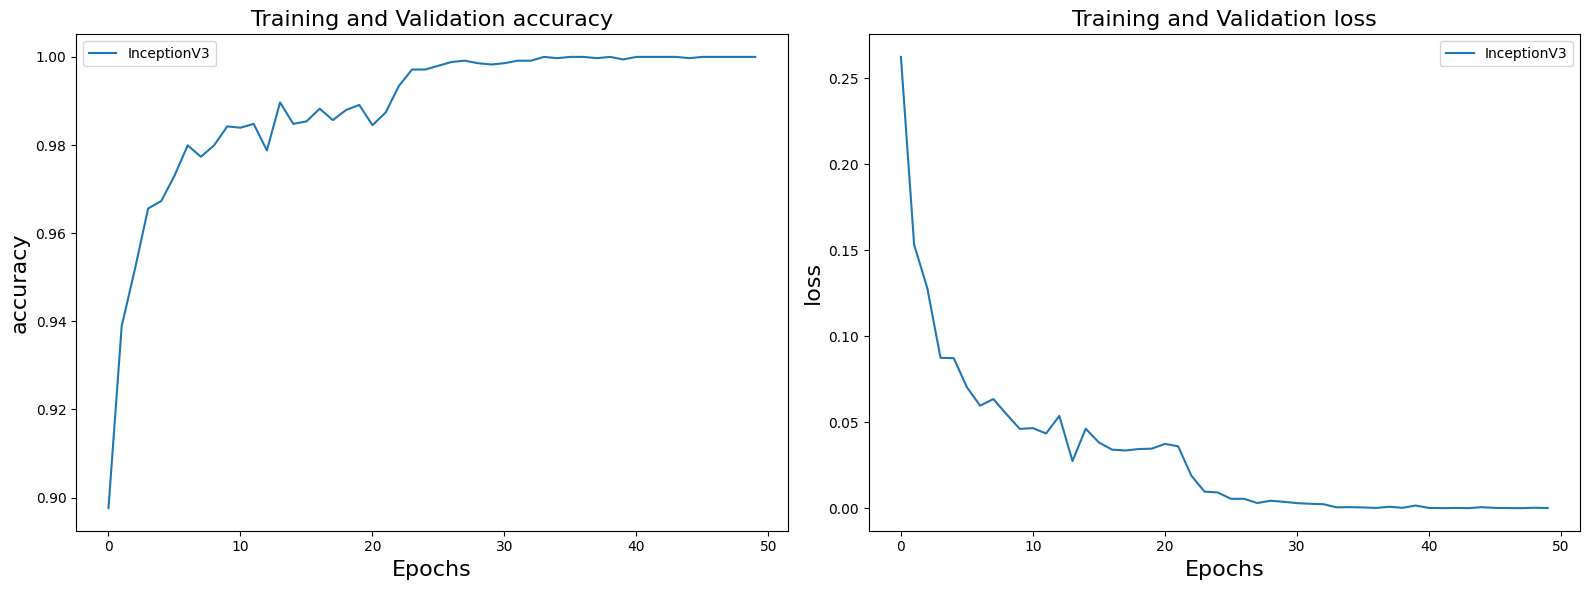

In [21]:
metrics_to_plot = ['accuracy', 'loss']

fig, axes = plt.subplots(len(metrics_to_plot), 1, figsize=(16, 6))

for i, metric in enumerate(metrics_to_plot):
    plt.subplot(1, 2, i+1)  # Create subplots for each metric
    for idx, history in enumerate(model_histories):
        plt.plot(history[metric], label=Models_NAMES[idx])
    plt.title(f'Training and Validation {metric}', fontsize=16)
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel(metric, fontsize=16)
    plt.legend()

plt.tight_layout()
plt.show()

## Test the model

In [23]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

print(f"test_df size   : {ts_length}")
print(f"Test Batch Size: {test_batch_size}")
print(f"Test Steps     : {test_steps}")

start_time = time.time()

test_score  = model.evaluate(test_gen, steps= test_steps, verbose= 0)

inference_time = time.time() - start_time
print('-' * 20)
print("\nInference Time: {:.6f} seconds".format(inference_time))

print('-' * 20)
print(f"Test Loss: {test_score [0]}")
print(f"Test Accuracy: {test_score [1]}")

test_df size   : 499
Test Batch Size: 1
Test Steps     : 499
--------------------

Inference Time: 12.100881 seconds
--------------------
Test Loss: 0.17207051813602448
Test Accuracy: 0.9759519100189209


## Plot classification metrics

499/499 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


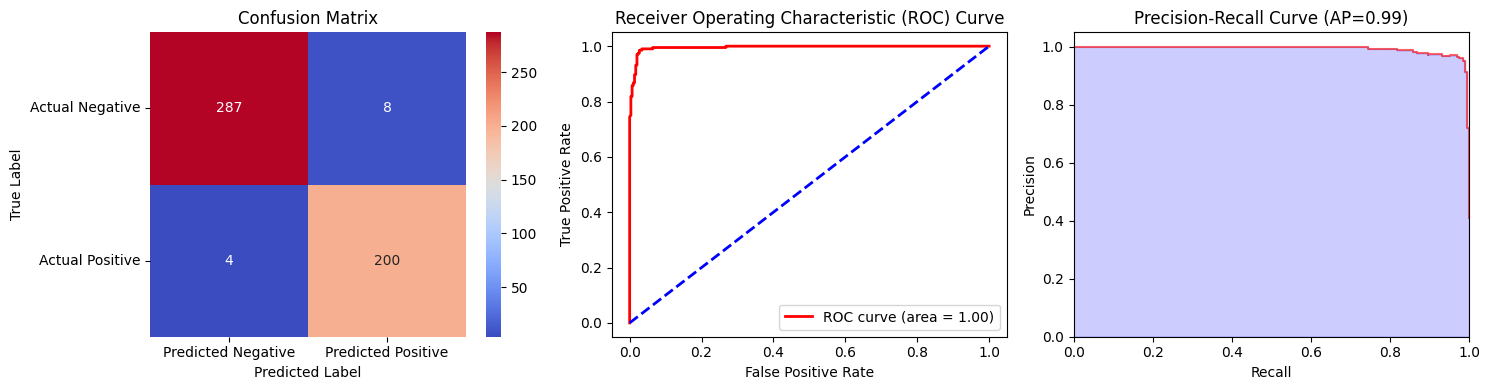

In [30]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import seaborn as sns

# Confusion Matrix
true_labels = test_gen.classes
predictions = model.predict(test_gen)
binary_predictions = [1 if pred > 0.5 else 0 for pred in predictions]

plt.figure(figsize=(15, 4))

# Plot Confusion Matrix
plt.subplot(1, 3, 1)
conf_matrix = confusion_matrix(true_labels, binary_predictions)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='coolwarm', 
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.yticks(rotation=0)

# Plot ROC Curve
plt.subplot(1, 3, 2)
fpr, tpr, thresholds = roc_curve(true_labels, predictions)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Plot Precision-Recall Curve
plt.subplot(1, 3, 3)
precision, recall, _ = precision_recall_curve(true_labels, predictions)
average_precision = average_precision_score(true_labels, predictions)
plt.step(recall, precision, color='r', alpha=0.6, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve (AP={0:.2f})'.format(average_precision))

plt.tight_layout()
plt.show()

## Confusion Matrix scores, ravelled

In [31]:
tn, fp, fn, tp = conf_matrix.ravel()
accuracy = round((tp + tn) / (tp + tn + fp + fn) * 100, 2)
precision = round(tp / (tp + fp) * 100, 2) if (tp + fp) != 0 else 0
recall = round(tp / (tp + fn) * 100, 2) if (tp + fn) != 0 else 0
f1_score = round(2 * (precision * recall) / (precision + recall), 2) if (precision + recall) != 0 else 0

print(f"\nTrue Positive  = {tp}")
print(f"False Positive = {fp}")
print(f"True Negative  = {tn}")
print(f"False Negative = {fn}")
print('\nAccuracy  = {:.4f}'.format(accuracy))
print('Precision = {:.4f}'.format(precision))
print('Recall    = {:.4f}'.format(recall))
print('F1 Score  = {:.4f}'.format(f1_score))


True Positive  = 200
False Positive = 8
True Negative  = 287
False Negative = 4

Accuracy  = 97.6000
Precision = 96.1500
Recall    = 98.0400
F1 Score  = 97.0900


In [10]:
INET_IMG_DIR = os.path.join(os.getcwd(), 'internet_img/')

try:
    shutil.rmtree(INET_IMG_DIR)
    print(f"Directory '{INET_IMG_DIR}' deleted successfully.")
except FileNotFoundError:
    pass

os.makedirs(INET_IMG_DIR, exist_ok=True)

In [11]:
def download_image_with_number(url, save_path, gender):
  # Extract the base filename (without extension) from the path
  basename = os.path.splitext(os.path.basename(save_path))[0]

  # Get the current highest number based on existing files
  highest_number = 0
  for filename in os.listdir(save_path):
    match = re.search(rf"{gender}_(\d+)", filename)
    if match:
      highest_number = max(highest_number, int(match.group(1)))

  # Generate new filename with incremented number and appropriate extension
  new_number = str(highest_number + 1).zfill(3)  # Pad with zeros to 3 digits
  filename = f"{save_path}{gender}_{new_number}.jpg"  # Assuming JPG format

  try:
    response = requests.get(url, stream=True)
    response.raise_for_status()

    with open(filename, 'wb') as f:
      for chunk in response.iter_content(1024):
        f.write(chunk)

    print(f"Image downloaded successfully from {url} and saved to {filename}")
  except requests.exceptions.RequestException as e:
    print(f"Error downloading image: {e}")

In [19]:
import requests
import re

image_url = "https://3.bp.blogspot.com/-lHgAnrx9xFU/WYcOdaftv4I/AAAAAAAAAtY/32vSoUSst1cadnet_Cwm1K69bVCIfmbnwCLcBGAs/s1600/Foto%2BIr%2BSukarno.jpg"
download_image_with_number(image_url, INET_IMG_DIR, "male")

image_url = "https://1.bp.blogspot.com/-qTcfI6Hs8Gg/TiA4zgjSKkI/AAAAAAAAAHs/R2sWS_KcCSg/w1200-h630-p-k-no-nu/soeharto%252C.jpg"
download_image_with_number(image_url, INET_IMG_DIR, "male")

image_url = "https://www.thoughtco.com/thmb/h1reaISnCmBBOgqh8dxAjgJb3JA=/3000x1941/filters:no_upscale():max_bytes(150000):strip_icc()/MegawatibyDimasArdianGetty2004-56a041d63df78cafdaa0b54b.jpg"
download_image_with_number(image_url, INET_IMG_DIR, "female")

image_url = "https://blogger.googleusercontent.com/img/b/R29vZ2xl/AVvXsEj7r6CXQ-zB3SRF-qdCCyOBBwtPm_1mU6oL7JQGr8TQjyww41jBp7QE096yQl6sc-ZpPDCQwosIw7vS2gOEjGHOHZPME8Tpnf0fu5qeQGkRM6DzbzOzyALIM5Np756BWBGVhawmrRokKoRQRtJmz2zu2oYE62glkaNe2KAcRy6V1I5WmUm4yYuzZyjSeg/s1136/Biografi%20Bu%20Puan%20Maharani,%20Putri%20Bu%20Megawati%20Soekarnoputri%20dan%20Cucu%20Bung%20Karno%20Sang%20Proklamator.jpg"
download_image_with_number(image_url, INET_IMG_DIR, "female")

image_url = "https://thumbs.dreamstime.com/b/handsome-latino-man-20185194.jpg"
download_image_with_number(image_url, INET_IMG_DIR, "male")

image_url = "https://i.pinimg.com/736x/ac/68/7c/ac687c962a1c40f23360c45b20c4d31a--beauty-queens-universe.jpg"
download_image_with_number(image_url, INET_IMG_DIR, "female")

image_url = "https://i.pinimg.com/originals/9f/a3/e4/9fa3e48c7f9696ee4bf337af74136a28.jpg"
download_image_with_number(image_url, INET_IMG_DIR, "male")

image_url = "https://www.ursulasweeklywanders.com/wp-content/uploads/2020/02/08-22825-post/000003-Enga-Woman_1803.jpg"
download_image_with_number(image_url, INET_IMG_DIR, "female")

image_url = "https://allthatsinteresting.com/wordpress/wp-content/uploads/2014/05/old-eskimo.jpg"
download_image_with_number(image_url, INET_IMG_DIR, "male")

image_url = "https://live.staticflickr.com/4105/4951753576_91e36b48cc_o.jpg"
download_image_with_number(image_url, INET_IMG_DIR, "female")

image_url = "https://images.saymedia-content.com/.image/t_share/MTc0NDg2ODMwMjY2MTk3MzUy/top-10-kpop-male-solo-artists.jpg"
download_image_with_number(image_url, INET_IMG_DIR, "male")

image_url = "https://i.pinimg.com/originals/90/39/a7/9039a708273088667c4562cab89c39e6.jpg"
download_image_with_number(image_url, INET_IMG_DIR, "female")

image_url = "https://1.bp.blogspot.com/-rUOpHKW7HiU/Xyu01mP955I/AAAAAAAA_CM/HDly5twbSpcu_YiabKguiz4QZqT5UEnnQCLcBGAsYHQ/s500/75a655086de9e657eeb1699ed4fccbf2.jpg"
download_image_with_number(image_url, INET_IMG_DIR, "male")

Image downloaded successfully from https://3.bp.blogspot.com/-lHgAnrx9xFU/WYcOdaftv4I/AAAAAAAAAtY/32vSoUSst1cadnet_Cwm1K69bVCIfmbnwCLcBGAs/s1600/Foto%2BIr%2BSukarno.jpg and saved to /kaggle/working/internet_img/male_009.jpg
Image downloaded successfully from https://1.bp.blogspot.com/-qTcfI6Hs8Gg/TiA4zgjSKkI/AAAAAAAAAHs/R2sWS_KcCSg/w1200-h630-p-k-no-nu/soeharto%252C.jpg and saved to /kaggle/working/internet_img/male_010.jpg
Image downloaded successfully from https://www.thoughtco.com/thmb/h1reaISnCmBBOgqh8dxAjgJb3JA=/3000x1941/filters:no_upscale():max_bytes(150000):strip_icc()/MegawatibyDimasArdianGetty2004-56a041d63df78cafdaa0b54b.jpg and saved to /kaggle/working/internet_img/female_006.jpg
Image downloaded successfully from https://blogger.googleusercontent.com/img/b/R29vZ2xl/AVvXsEj7r6CXQ-zB3SRF-qdCCyOBBwtPm_1mU6oL7JQGr8TQjyww41jBp7QE096yQl6sc-ZpPDCQwosIw7vS2gOEjGHOHZPME8Tpnf0fu5qeQGkRM6DzbzOzyALIM5Np756BWBGVhawmrRokKoRQRtJmz2zu2oYE62glkaNe2KAcRy6V1I5WmUm4yYuzZyjSeg/s1136/Biografi%2

In [20]:
from glob import glob
from tensorflow.keras.preprocessing import image
import numpy as np
from keras.applications.mobilenet_v2 import preprocess_input
# Path to the directory containing images
# image_folder = "/kaggle/working/internet_img/"

# Get all image paths in the folder
image_paths = glob(f"{INET_IMG_DIR}*.jpg")  # Modify pattern if using different format

for image_path in image_paths:
  # Load the image
  img = image.load_img(image_path, target_size=img_size)
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array = preprocess_input(img_array)

  # Make the prediction using the saved model
  prediction = model.predict(img_array)

  print(f"Prediction {prediction}")

  # Convert prediction probabilities to percentages
  female_prob = round(1 - prediction[0][0] * 100, 2)
  male_prob = round(prediction[0][0] * 100, 2)

  # Interpret the prediction result
  if male_prob > female_prob:
    result = "Male"
  else:
    result = "Female"

  plt.figure(figsize=(8, 4))

  plt.subplot(1, 2, 1)
  img = Image.open(image_path)
  plt.imshow(img)
  plt.axis('off')
  plt.title('Test Image')

  plt.tight_layout()
  plt.show()

  print(f"Image: {image_path}")
  print(f"Model predicts: {result}")
  print("-" * 30)  # Print a separator for clarity between images

NameError: name 'model' is not defined